In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_19/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames,
                                    #verbose=2
                                   )

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 0 small face classifier and 3 large face classifier models.
0 - Large face model: ../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_02_14-f4
1 - Large face model: ../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_03_12-f2
2 - Large face model: ../kaggle_datasets/deepfake_2020_03_19/large_face_classifier/2020_03_18_f3
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 1 face sequence classifier models.
Loaded 5 second level xgb classifier models, 5 logistic regression models and 0 LightGBM models
##################################################
DeepFakeDetector v.0.8.1
Sample 10 first frames and 10 spaced frames.
Number of max retries is 4
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 70


array(['large_face_clf_mean_0_original_first', 'large_face_clf_max_0_original_first',
       'large_face_clf_std_0_original_first', 'large_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_0_bright_mean', 'seq_clf_len-5_start-10_0_bright_max',
       'seq_clf_len-5_start-10_0_zoom_mean', 'seq_clf_len-5_start-10_0_zoom_max'], dtype='<U48')

In [9]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[2], apply_augmentations=True) # 9008, 43337, 8298
feats

CPU times: user 8.25 s, sys: 336 ms, total: 8.59 s
Wall time: 3.53 s


[array([0.974601, 0.980564, 0.005194, 0.977278, ..., 0.953034, 0.954609, 0.918936, 0.937537])]

In [10]:
for (feat, name) in zip(feats[0],featNames):
    print(feat, name)

0.9746013118831044 large_face_clf_mean_0_original_first
0.9805639386177063 large_face_clf_max_0_original_first
0.00519414230246931 large_face_clf_std_0_original_first
0.9772777557373047 large_face_clf_median_0_original_first
0.9784562587738037 large_face_clf_Q3_0_original_first
0.981292492836902 large_face_clf_mean_0_original_spaced
0.9847198724746704 large_face_clf_max_0_original_spaced
0.00476670419987443 large_face_clf_std_0_original_spaced
0.9828910231590271 large_face_clf_median_0_original_spaced
0.9837171584367752 large_face_clf_Q3_0_original_spaced
0.9068060684364264 large_face_clf_mean_1_original_first
0.9211791157722473 large_face_clf_max_1_original_first
0.00952457210129246 large_face_clf_std_1_original_first
0.9058743715286255 large_face_clf_median_1_original_first
0.9111281931400299 large_face_clf_Q3_1_original_first
0.9185542384321141 large_face_clf_mean_1_original_spaced
0.9431018233299255 large_face_clf_max_1_original_spaced
0.011272808420998787 large_face_clf_std_1_orig

In [11]:
datasOfTrackedPersons = deepFakeDetector.GetFeatures(filenames[0],return_data=True, apply_augmentations=True)

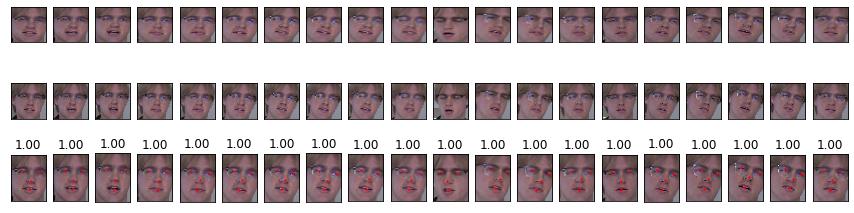

In [12]:
from detectorDebugUtils import *
plotFaceSamples(datasOfTrackedPersons, n_frames=20)

In [13]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
7,hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
25,sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
26,eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
27,mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
31,kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


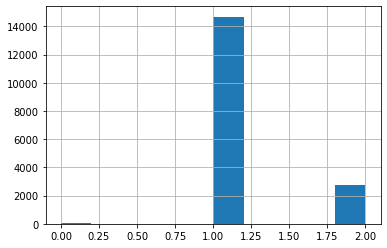

In [14]:
df.person_count.hist()

In [15]:
df.first_person_label.describe()

count    17461.000000
mean         1.565775
std          1.291520
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: first_person_label, dtype: float64

In [16]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


In [17]:
df_one_person = df[df['person_count']==1]
fake_real_ratio = len(df_one_person[df_one_person['label']=='FAKE']) / len(df_one_person[df_one_person['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 2.7 times more fakes


In [18]:
MISSING_VAL = 0.5

In [19]:
df_one_person.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17
lxkyjjvhox.mp4,FAKE,2nd_level,True,0,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, ...",NaN,mjqtuozaey.mp4,2020-02-17


In [20]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

subsample = 1000

#raw lists
preds_fake = []
preds_real = []

split_fake = []
split_real = []

keys=df_one_person.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):#[:subsample])):
    if i%500==0: # all garbage is not handled right
        gc.collect()
        
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    if plain_name not in keys:
        continue
    is_fake = True if df_one_person.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df_one_person.at[plain_name,'cv_fold']
    try:
        preds = deepFakeDetector.GetFeatures(str(filename), apply_augmentations=True)
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        if is_fake:
            preds_fake.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_fake.append(split)
        else:
            preds_real.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_real.append(split)
        continue
        
    def _addPred(preds, split, is_fake):
        if is_fake:
            preds_fake.append(preds)
            split_fake.append(split)
        else:
            preds_real.append(preds)
            split_real.append(split)
    
    # preds can have two persons
    if len(preds) > 1:
        continue # skip for now
        # include both
        first_label = df_one_person.loc[plain_name]['first_person_label']
        second_label = df_one_person.loc[plain_name]['second_person_label']
        if first_label == 0:
            _addPred(preds[0], split, False)
        elif first_label > 0:
            _addPred(preds[0], split, True)
            
        # this assumes the face order is the same
        if second_label == 0:
            _addPred(preds[1], split, False)
        elif second_label > 0:
            _addPred(preds[1], split, True)
    else:
        _addPred(preds[0], split, is_fake)

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/poahumqnsp.mp4 - 1239
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/vbylthsdar.mp4 - 1675
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/ewhdymgjmo.mp4 - 22535
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/sjeyosrvxx.mp4 - 24189
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/tuzqnzmysx.mp4 - 24384
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/usjaafgemb.mp4 - 24516
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_12/niuurktsiv.mp4 - 28435
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/kzvzrzyrsp.mp4 - 46734
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/sxrorqczon.mp4 - 47364
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/uunrfposre.mp4 - 47505
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/De

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/bthkrdubbz.mp4 - 109095
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/dbthqamhyz.mp4 - 109188
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/eecvubghfz.mp4 - 109280
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/egjrqbcgym.mp4 - 109286
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ehwcyxmtmb.mp4 - 109295
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ehwoohpulw.mp4 - 109296
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ekwglpkqms.mp4 - 109303
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/fiiqfocsvl.mp4 - 109352
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/fxgpgffbkt.mp4 - 109404
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/gndwznamgn.mp4 - 109451
Error with /mnt/945C2D6E5C2D4B

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/uxlrcicjge.mp4 - 115697
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/xmephobexu.mp4 - 115789
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/agblhurdrh.mp4 - 116040
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/apdmamltet.mp4 - 116073
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/avlbihahvk.mp4 - 116117
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/axsgyeohxb.mp4 - 116126
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bmgidxpirq.mp4 - 116191
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bvfxnmejnh.mp4 - 116235
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cimlotvwxy.mp4 - 116296
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/dermobcmbu.mp4 - 116393
Error with /mnt/945C2D6E5C2D4B

In [21]:
# is the set balanced?
print(len(preds_real), len(preds_fake))

3945 3773


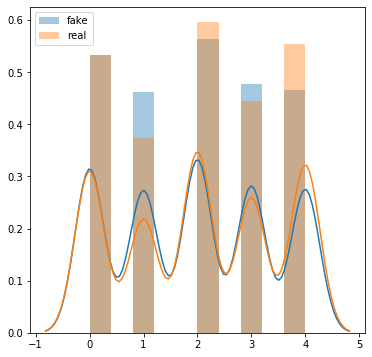

In [22]:
# are the splits balanced?
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(split_fake,bins=10, ax=ax, label='fake')
sns.distplot(split_real,bins=10, ax=ax, label='real')
ax.legend()

# Plot distributions for each feature

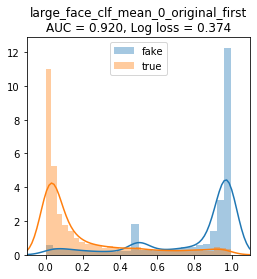

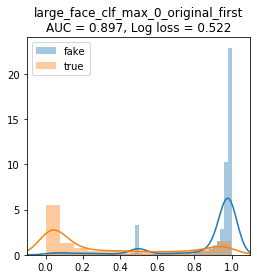

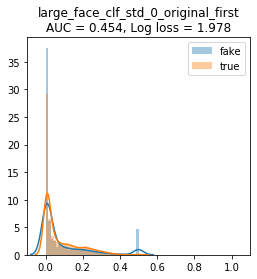

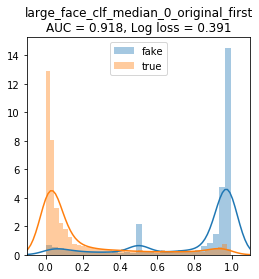

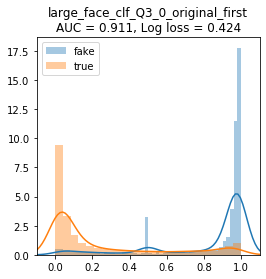

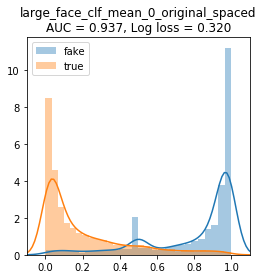

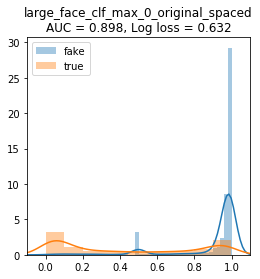

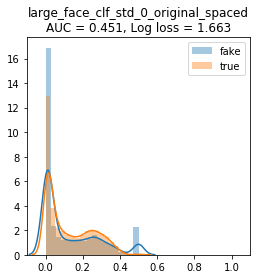

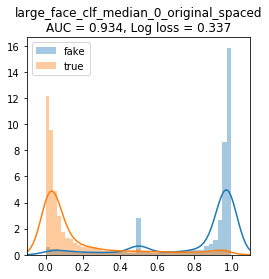

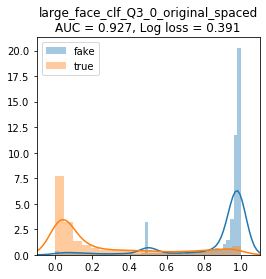

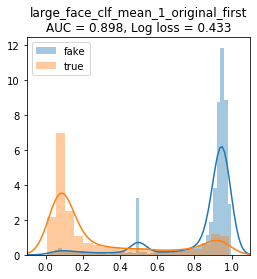

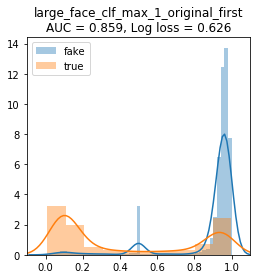

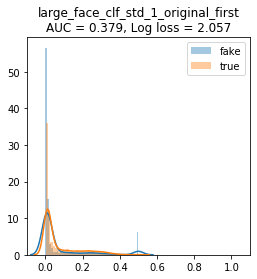

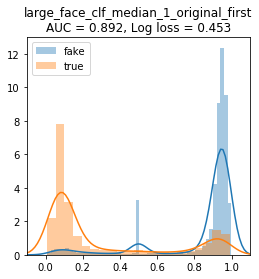

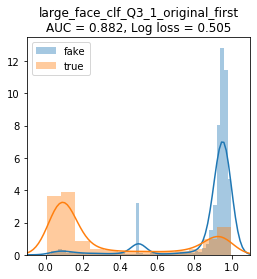

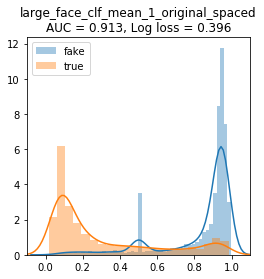

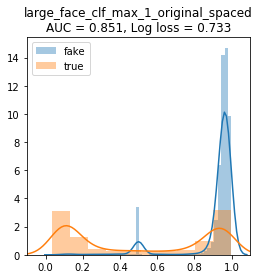

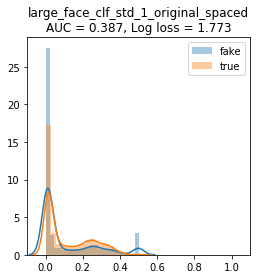

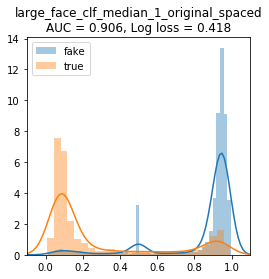

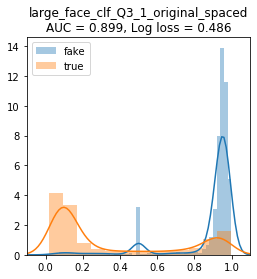

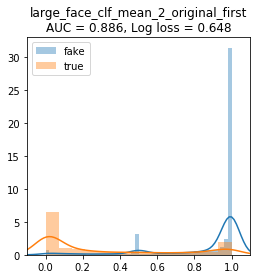

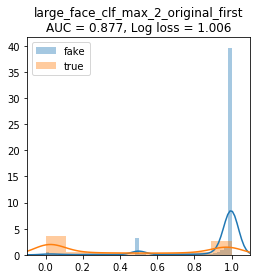

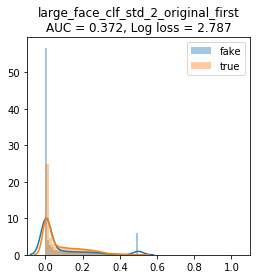

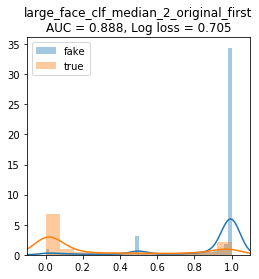

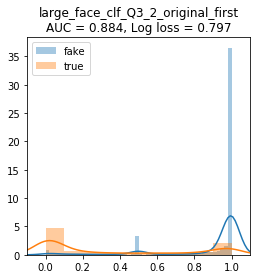

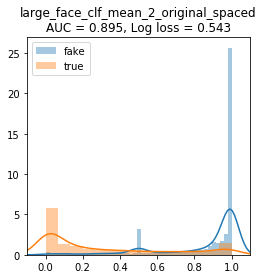

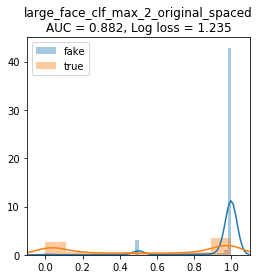

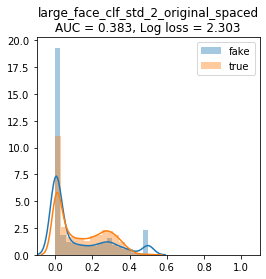

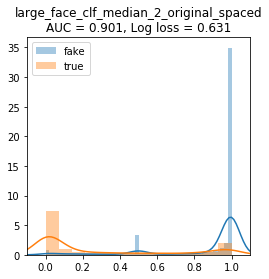

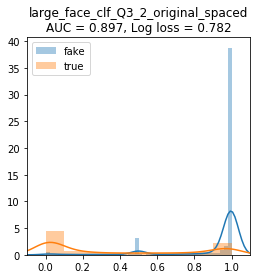

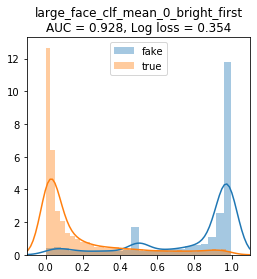

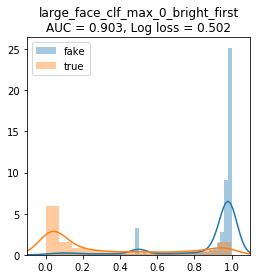

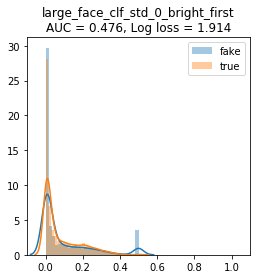

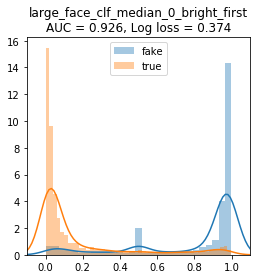

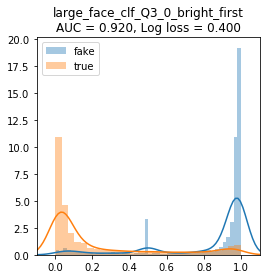

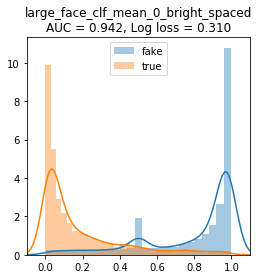

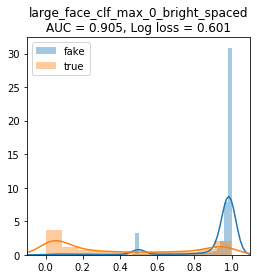

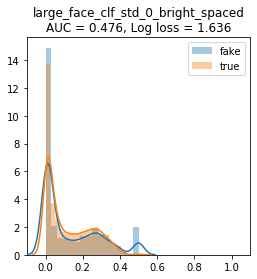

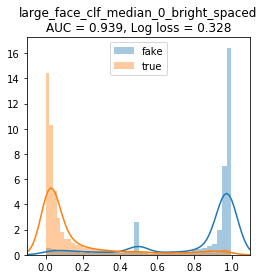

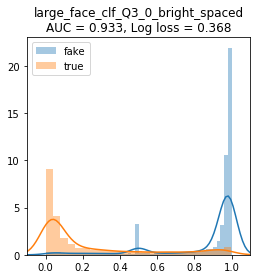

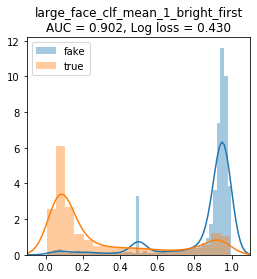

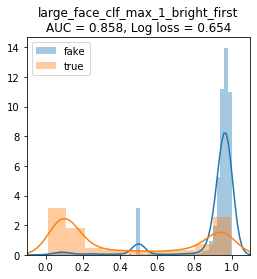

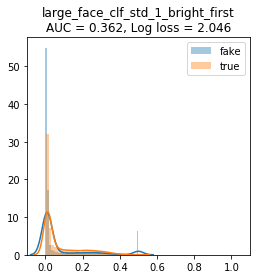

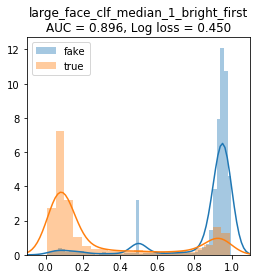

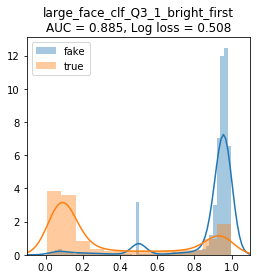

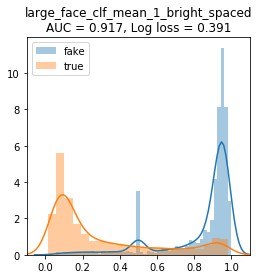

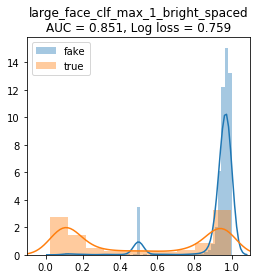

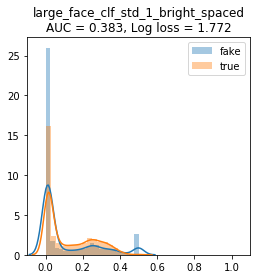

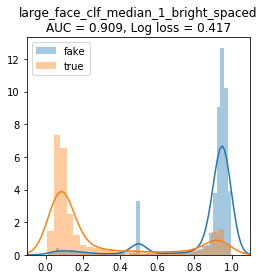

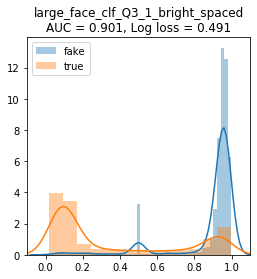

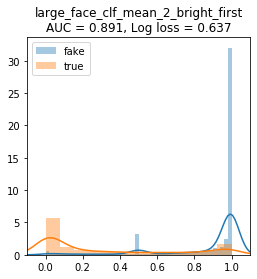

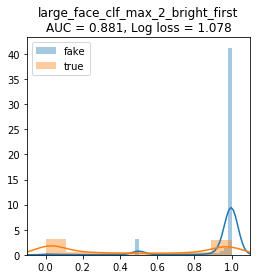

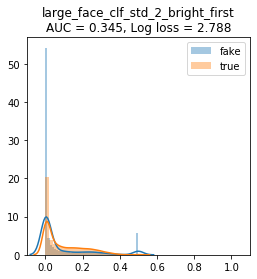

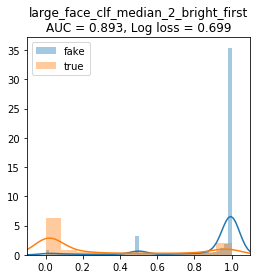

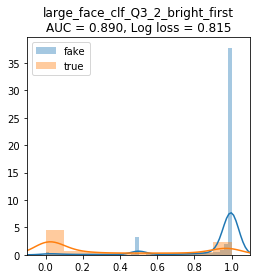

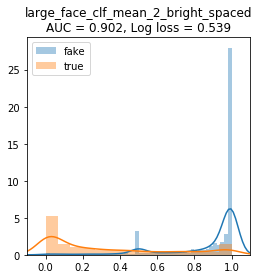

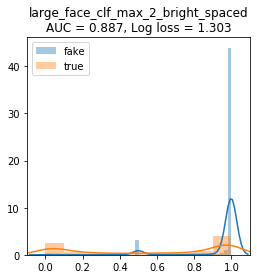

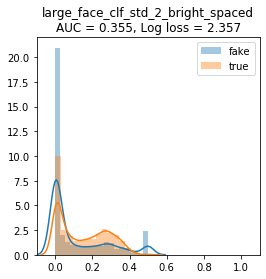

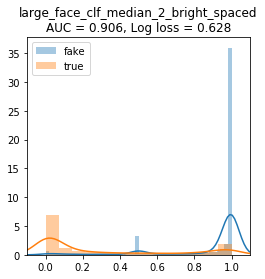

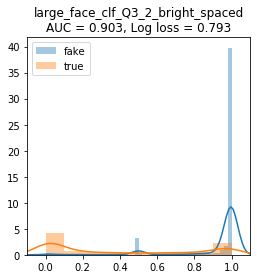

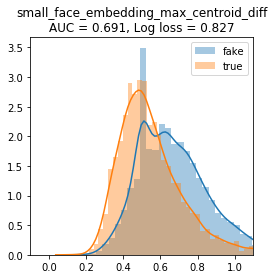

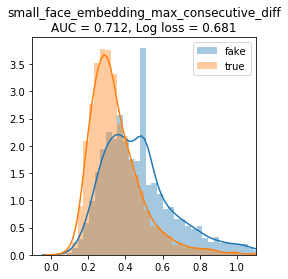

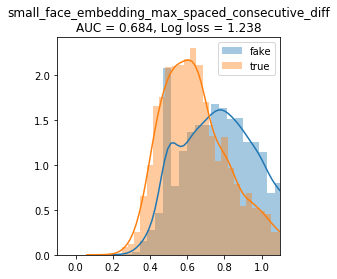

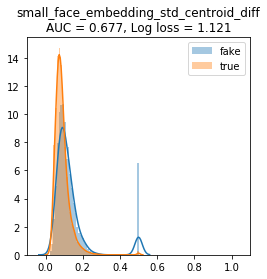

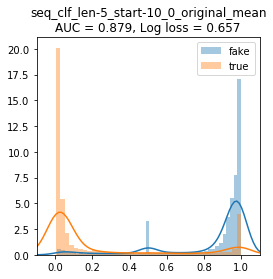

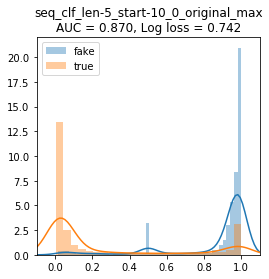

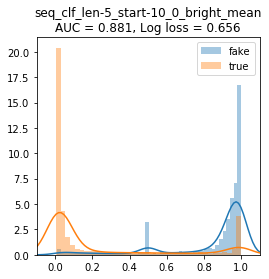

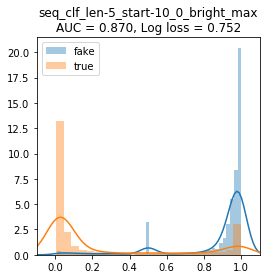

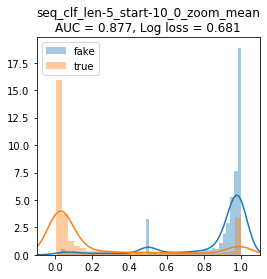

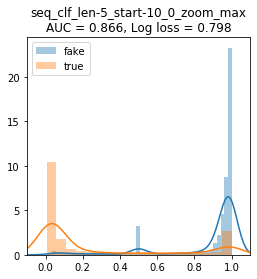

In [23]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

def plotFakeReal(feature_index):
    fake_list = list(np.array(preds_fake)[:,feature_index])
    real_list = list(np.array(preds_real)[:,feature_index])
    auc = getAuc(fake_list, real_list)
    logloss = getLogLoss(fake_list, real_list)
    f, ax = plt.subplots(1,1,figsize=(4,4))
    sns.distplot(fake_list, ax=ax, label='fake')
    sns.distplot(real_list, ax=ax, label='true')
    ax.set_title(featNames[feature_index] + '\n' + 'AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
    ax.set_xlim(-0.1,1.1)
    #ax.set_ylim(0,5)
    ax.legend()
    plt.show()

for i in range(preds_fake[0].shape[0]):
    plotFakeReal(i)

# Feature classifier from XGBoost

In [24]:
# collect vectors
ys = np.concatenate([np.ones(len(preds_fake)), np.zeros(len(preds_real))])
xs_fake = np.array(preds_fake)
xs_real = np.array(preds_real)
xs = np.concatenate([xs_fake, xs_real], axis=0)
splits = np.concatenate([split_fake, split_real])
print(ys.shape)
print(xs.shape)
print(splits.shape)

(7718,)
(7718, 70)
(7718,)


In [25]:
# save for later
np.save("./saved_val_xs.npy", xs)
np.save("./saved_val_ys.npy", ys)
np.save("./saved_val_splits.npy", splits)

# Checkpoint

In [9]:
xs = np.load("./saved_val_xs.npy")
ys = np.load("./saved_val_ys.npy")
splits = np.load("./saved_val_splits.npy")

In [26]:
np.unique(splits, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1645, 1287, 1789, 1420, 1577]))

In [27]:
def getSplitParts(fold=0, removeMissing=False):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for x,y,f in zip(xs,ys,splits):
        if(removeMissing and x[0]==MISSING_VAL):
            continue
        if f==999: # error cases
            continue
        if f==fold:
            X_test.append(x)
            y_test.append(y)
        else:
            X_train.append(x)
            y_train.append(y)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [28]:
DIR_SECOND_LEVEL = '../models/second_level_models'
if not os.path.exists(DIR_SECOND_LEVEL):
    os.mkdir(DIR_SECOND_LEVEL)
DIR_EXPERIMENT = os.path.join(DIR_SECOND_LEVEL, '2020_03_19-augmentations')
if not os.path.isdir(DIR_EXPERIMENT):
    os.mkdir(DIR_EXPERIMENT)

In [29]:
from sklearn.metrics import log_loss
import xgboost as xgb

losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
xgb_models = []
eps = 1e-6
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = "logloss"
    
    model = xgb.XGBClassifier(objective='binary:logistic',#'reg:squarederror', 
                             learning_rate = 0.10, 
                             max_depth = 3,
                             gamma=5,
                             subsample = 0.8,
                             colsample_bytree = 1,
                             reg_lambda=1,
                             reg_alpha=0.3,
                             alpha = 10, 
                             n_estimators = 80,
                             missing=MISSING_VAL)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    model.save_model(str(os.path.join(DIR_EXPERIMENT,'second_level_xgb_{0}.bin'.format(fold))))
    xgb_models.append(model)
    
    y_pred = np.clip(model.predict_proba(X_test)[:,1],eps,1-eps)
    y_pred_train = np.clip(model.predict_proba(X_train)[:,1],eps,1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.157, val_loss: 0.254
Fold 1 train_loss: 0.161, val_loss: 0.242
Fold 2 train_loss: 0.166, val_loss: 0.212
Fold 3 train_loss: 0.158, val_loss: 0.261
Fold 4 train_loss: 0.171, val_loss: 0.185

Mean train_loss 0.162, val_loss 0.231
train loss std 0.005, val loss std 0.028


Text(0.5, 1.0, 'Mean loss: 0.231')

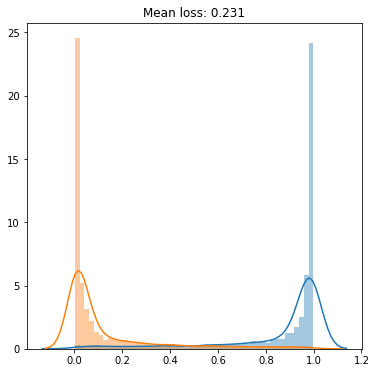

In [30]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

## Weight analysis - eli5

In [31]:
for model in xgb_models:
    display(eli5.explain_weights_xgboost(model, feature_names=featNames))

Weight,Feature
0.3252,large_face_clf_mean_0_original_spaced
0.2654,large_face_clf_mean_0_bright_spaced
0.0721,large_face_clf_mean_1_bright_spaced
0.0303,large_face_clf_Q3_0_bright_first
0.0255,large_face_clf_mean_1_bright_first
0.0199,large_face_clf_median_0_bright_spaced
0.0151,large_face_clf_median_0_original_spaced
0.0142,large_face_clf_Q3_2_bright_first
0.0133,seq_clf_len-5_start-10_0_bright_mean
0.0110,large_face_clf_max_2_bright_spaced


Weight,Feature
0.3605,large_face_clf_mean_0_bright_spaced
0.0841,large_face_clf_mean_0_original_spaced
0.0781,large_face_clf_Q3_0_original_spaced
0.0360,large_face_clf_mean_1_bright_first
0.0320,large_face_clf_mean_0_bright_first
0.0290,seq_clf_len-5_start-10_0_bright_mean
0.0240,large_face_clf_Q3_2_bright_spaced
0.0228,large_face_clf_median_0_bright_spaced
0.0222,large_face_clf_median_0_bright_first
0.0202,large_face_clf_max_2_bright_spaced


Weight,Feature
0.2269,large_face_clf_mean_0_bright_spaced
0.1150,large_face_clf_median_1_bright_spaced
0.1071,large_face_clf_Q3_1_bright_spaced
0.0972,large_face_clf_mean_0_original_spaced
0.0472,large_face_clf_Q3_0_bright_spaced
0.0351,large_face_clf_mean_1_bright_spaced
0.0264,seq_clf_len-5_start-10_0_bright_max
0.0262,large_face_clf_median_0_bright_spaced
0.0227,large_face_clf_Q3_0_original_spaced
0.0188,large_face_clf_max_2_bright_spaced


Weight,Feature
0.3646,large_face_clf_mean_0_bright_spaced
0.0618,large_face_clf_Q3_1_bright_spaced
0.0490,large_face_clf_mean_1_bright_spaced
0.0358,large_face_clf_max_2_bright_spaced
0.0281,large_face_clf_mean_0_original_spaced
0.0262,seq_clf_len-5_start-10_0_bright_mean
0.0210,large_face_clf_max_2_bright_first
0.0209,large_face_clf_median_0_bright_spaced
0.0208,large_face_clf_Q3_2_bright_spaced
0.0201,large_face_clf_max_0_bright_spaced


Weight,Feature
0.2546,large_face_clf_mean_0_original_spaced
0.1850,large_face_clf_mean_0_bright_spaced
0.0577,large_face_clf_Q3_0_bright_spaced
0.0358,large_face_clf_Q3_2_bright_spaced
0.0318,large_face_clf_median_0_bright_first
0.0291,seq_clf_len-5_start-10_0_bright_mean
0.0273,large_face_clf_max_0_original_spaced
0.0220,large_face_clf_mean_0_bright_first
0.0192,large_face_clf_median_0_bright_spaced
0.0159,large_face_clf_Q3_0_original_spaced


In [32]:
pd.DataFrame({'Variable':featNames,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
5,large_face_clf_mean_0_original_spaced,0.254632
35,large_face_clf_mean_0_bright_spaced,0.184982
39,large_face_clf_Q3_0_bright_spaced,0.057658
59,large_face_clf_Q3_2_bright_spaced,0.035827
33,large_face_clf_median_0_bright_first,0.031821
...,...,...
50,large_face_clf_mean_2_bright_first,0.002093
0,large_face_clf_mean_0_original_first,0.002089
28,large_face_clf_median_2_original_spaced,0.002040
10,large_face_clf_mean_1_original_first,0.000000


## Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [34]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lr_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    
    clf = LogisticRegression(random_state=0, 
                             max_iter=1000,
                             solver='lbfgs').fit(X_train, y_train)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_LogReg_{0}.sav'.format(fold)))
    #pickle.dump(clf, open(filename, 'wb'))
    #clf = pickle.load(open(filename,'rb'))
    joblib.dump(clf, filename)
    clf = joblib.load(filename)
    lr_models.append(clf)
    
    y_pred = np.clip(clf.predict_proba(X_test)[:,1],eps, 1-eps)
    y_pred_train = np.clip(clf.predict_proba(X_train)[:,1],eps, 1-eps)
    #y_pred = np.clip(y_pred,0.4,1.0)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.231, val_loss: 0.287
Fold 1 train_loss: 0.231, val_loss: 0.279
Fold 2 train_loss: 0.244, val_loss: 0.223
Fold 3 train_loss: 0.225, val_loss: 0.305
Fold 4 train_loss: 0.246, val_loss: 0.214

Mean train_loss 0.235, val_loss 0.261
train loss std 0.008, val loss std 0.036


Text(0.5, 1.0, 'Mean loss: 0.261')

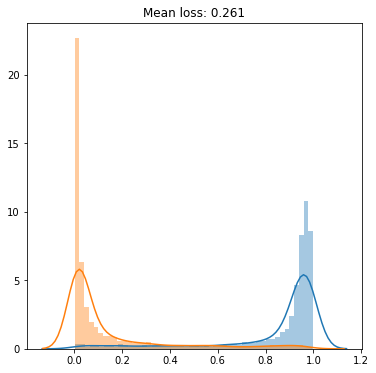

In [35]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

In [36]:
for clf in lr_models:
    display(eli5.explain_weights_sklearn(clf,feature_names=featNames))

Weight?,Feature
+2.066,large_face_clf_mean_0_original_spaced
+1.864,small_face_embedding_max_consecutive_diff
+1.696,small_face_embedding_max_spaced_consecutive_diff
+1.638,large_face_clf_mean_0_bright_spaced
+1.304,large_face_clf_mean_2_bright_spaced
+1.198,large_face_clf_mean_0_bright_first
+1.032,seq_clf_len-5_start-10_0_bright_max
+1.029,large_face_clf_Q3_2_bright_spaced
+0.828,large_face_clf_max_0_bright_first
+0.797,large_face_clf_median_0_original_spaced


Weight?,Feature
+2.295,large_face_clf_mean_0_bright_spaced
+2.229,small_face_embedding_max_spaced_consecutive_diff
+2.028,small_face_embedding_max_consecutive_diff
+1.947,large_face_clf_mean_0_original_spaced
+1.486,large_face_clf_Q3_2_bright_spaced
+1.395,large_face_clf_max_0_bright_spaced
+1.141,large_face_clf_mean_0_bright_first
+1.124,large_face_clf_mean_2_bright_spaced
+0.972,large_face_clf_mean_1_bright_spaced
+0.870,large_face_clf_std_2_bright_spaced


Weight?,Feature
+2.349,large_face_clf_mean_0_original_spaced
+2.110,large_face_clf_mean_0_bright_spaced
+2.059,small_face_embedding_max_consecutive_diff
+2.019,small_face_embedding_max_spaced_consecutive_diff
+1.340,large_face_clf_Q3_2_bright_spaced
+1.211,large_face_clf_mean_1_bright_spaced
+1.199,large_face_clf_std_2_bright_spaced
+1.171,large_face_clf_mean_0_bright_first
+1.031,large_face_clf_max_1_bright_spaced
+0.886,large_face_clf_mean_1_original_spaced


Weight?,Feature
+2.039,small_face_embedding_max_consecutive_diff
+1.944,large_face_clf_mean_0_original_spaced
+1.865,large_face_clf_mean_0_bright_spaced
+1.532,small_face_embedding_max_spaced_consecutive_diff
+1.401,large_face_clf_mean_2_bright_spaced
+1.270,large_face_clf_Q3_2_bright_spaced
+1.166,seq_clf_len-5_start-10_0_zoom_mean
+1.075,small_face_embedding_max_centroid_diff
+1.024,large_face_clf_Q3_0_bright_spaced
+0.971,large_face_clf_mean_0_bright_first


Weight?,Feature
+2.264,large_face_clf_mean_0_original_spaced
+2.256,small_face_embedding_max_consecutive_diff
+1.812,large_face_clf_mean_0_bright_spaced
+1.803,small_face_embedding_max_spaced_consecutive_diff
+1.396,large_face_clf_mean_1_bright_spaced
+1.324,large_face_clf_std_2_bright_spaced
+1.084,large_face_clf_max_0_bright_spaced
+1.058,large_face_clf_Q3_0_bright_spaced
+0.992,large_face_clf_mean_0_bright_first
+0.978,large_face_clf_max_0_bright_first


# LightGBM

In [37]:
import lightgbm as lgb

In [38]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lgb_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    param = {'num_leaves': 7,
             'boosting':'dart',
             'objective': 'binary',
             'metric': 'binary_logloss'}
    num_round = 300
    bst = lgb.train(param, 
                    train_data, 
                    num_round, 
                    valid_sets=[test_data],
                    #early_stopping_rounds=5,
                    verbose_eval=20)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_lgb_{0}.txt'.format(fold)))
    bst.save_model(filename, 
                   #num_iteration=bst.best_iteration
                  )
    bst = lgb.Booster(model_file=filename)  # init model
    
    lgb_models.append(bst)
    
    y_pred = np.clip(bst.predict(X_test),eps, 1-eps)
    y_pred_train = np.clip(bst.predict(X_train),eps, 1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

[20]	valid_0's binary_logloss: 0.316625
[40]	valid_0's binary_logloss: 0.274068
[60]	valid_0's binary_logloss: 0.267529
[80]	valid_0's binary_logloss: 0.264031
[100]	valid_0's binary_logloss: 0.26339
[120]	valid_0's binary_logloss: 0.262886
[140]	valid_0's binary_logloss: 0.258936
[160]	valid_0's binary_logloss: 0.258907
[180]	valid_0's binary_logloss: 0.257074
[200]	valid_0's binary_logloss: 0.253766
[220]	valid_0's binary_logloss: 0.25451
[240]	valid_0's binary_logloss: 0.254746
[260]	valid_0's binary_logloss: 0.253593
[280]	valid_0's binary_logloss: 0.254047
[300]	valid_0's binary_logloss: 0.252898
Fold 0 train_loss: 0.138, val_loss: 0.253
[20]	valid_0's binary_logloss: 0.30127
[40]	valid_0's binary_logloss: 0.260425
[60]	valid_0's binary_logloss: 0.256662
[80]	valid_0's binary_logloss: 0.250544
[100]	valid_0's binary_logloss: 0.249285
[120]	valid_0's binary_logloss: 0.245224
[140]	valid_0's binary_logloss: 0.243604
[160]	valid_0's binary_logloss: 0.244574
[180]	valid_0's binary_log

In [39]:
preds

[array([0.962162, 0.293356, 0.662738, 0.73969 , ..., 0.006486, 0.043121, 0.032832, 0.022717]),
 array([0.576563, 0.638393, 0.92365 , 0.788632, ..., 0.019132, 0.253486, 0.591792, 0.231904]),
 array([0.980278, 0.216199, 0.882969, 0.178951, ..., 0.001583, 0.027555, 0.006546, 0.001228]),
 array([0.986204, 0.997224, 0.994756, 0.983239, ..., 0.002045, 0.008128, 0.975698, 0.002764]),
 array([0.992918, 0.993966, 0.995241, 0.994256, ..., 0.001662, 0.001617, 0.001814, 0.829966])]

Text(0.5, 1.0, 'Mean loss: 0.228')

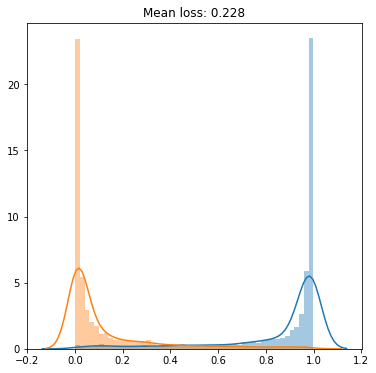

In [40]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))